In [26]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import scipy.stats as st
from scipy.optimize import minimize
from scipy.integrate import trapezoid, cumulative_trapezoid

import emcee
import corner

In [27]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

In [28]:
def f_x(x, x0, f_a=1, l0=30, xi=0.23, a=0.52, delta=1, theta2=2.5):

    # Occupation function
    focc =  1/(1 + delta * np.exp(-theta2*(x - x0)))**(1/delta)

    return f_a * focc

In [29]:
def log_likelihood(theta, x, y, xerr, yerr, p_obs):

    # parameters to be fit
    log_ms0, delta1, ep, log_lam_min, log_lam_max, log_lam_s, log_f, f_a, delta, theta2, l0, xi, a = theta
    BC = 0.7

    lam_min = 10**log_lam_min
    lam_max = 10**log_lam_max
    lam_s = 10**log_lam_s

    x_bh = 7.43 + 1.61*(x - np.log10(3e10)) # 0.81
    log_lam = y + BC - 38.2 - x_bh # residual

    dlogl = .01
    log_lam_eval = np.arange(log_lam_min, 1, dlogl)
    lam_eval = 10**log_lam_eval
    dlam_eval = np.diff(lam_eval)
    dlam_int = dlam_eval

    mask_det = (yerr > 0)
    
    # Residuals
    s2 = yerr**2 + np.exp(2*log_f)**2 + (xerr)**2
    s_ul2 = np.exp(2*log_f)**2 + (xerr)**2

    if np.min(log_lam[mask_det]) < log_lam_min: # min
        print('min')
        return -np.inf
        
    if np.max(log_lam[mask_det]) > log_lam_max: # max
        print('max')
        print(np.max(log_lam[mask_det]), log_lam_max)
        return -np.inf

    # [data axis], convolve axis, int axis
    log_lam_int = log_lam_eval - np.max(log_lam_eval) + log_lam[~mask_det, np.newaxis]
    y_int = log_lam_int - BC + 38.2 + x_bh[~mask_det, np.newaxis]
    dlam_int = dlam_eval

    # Type 1 fraction
    L =  10**y
    L_int = 10**y_int
    L0 = 10**l0
    f1 = 1 - (1 + 3*(L/L0)**(1 - 2*xi))**-a
    f1_int = 1 - (1 + 3*(L_int/L0)**(1 - 2*xi))**-a

    # pdf
    lam_C = 10**np.arange(log_lam_min, log_lam_max, .01)
    C = 1/trapezoid( ( (lam_C/lam_s)**delta1 + (lam_C/lam_s)**(delta1+ep) )**(-1), dx=np.diff(lam_C))

    pdf_pl = C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)
    pdf_norm = st.norm.pdf(log_lam[mask_det, np.newaxis] - log_lam_eval, scale=np.sqrt(s2[mask_det, np.newaxis]))
    pdf = trapezoid(pdf_pl * pdf_norm, dx=dlam_eval, axis=1)

    # cdf
    pdf_norm_int = st.norm.pdf(log_lam_eval[:, np.newaxis] - log_lam_eval, scale=np.sqrt(np.mean(s2[~mask_det])))
    pdf_int = trapezoid(pdf_pl * pdf_norm_int, dx=dlam_eval, axis=1)
    pdf_int[log_lam_eval < log_lam_min] = 0.0
    pdf_int[log_lam_eval > log_lam_max] = 0.0
    pdf_int_lam = np.array([np.interp(log_lam_int_i, log_lam_eval, pdf_int) for log_lam_int_i in log_lam_int])

    # data axis, int axis
    cdf = trapezoid(f1_int * pdf_int_lam, dx=dlam_int, axis=1)

    # Type 1 function (Oh 2015; https://ui.adsabs.harvard.edu/abs/2015ApJS..219....1O/abstract)
    f_occ_det = f_x(x[mask_det], log_ms0, f_a, l0, xi, a, delta, theta2)
    f_occ_cens = f_x(x[~mask_det], log_ms0, f_a, l0, xi, a, delta, theta2)
    
    # Probability distributions
    p_det = f1[mask_det] * f_occ_det * pdf
    p_cens = f_occ_cens * cdf + 1 - f_occ_cens

    # Clip
    p_det = np.clip(p_obs[mask_det] * p_det, 1e-12, 1)
    p_cens = np.clip(p_obs[~mask_det] * p_cens, 1e-12, 1)
    
    # Likelihood
    ll_det = np.log(p_det)
    ll_cens = np.log(p_cens)

    ll = np.sum(ll_det) + np.sum(ll_cens)
    
    return ll

In [30]:
def log_prior(theta):
    log_ms0, delta1, ep, log_lam_min, log_lam_max, log_lam_s, log_f, f_a, delta, theta2, l0, xi, a = theta

    # Power law priors
    if 5.0 < log_ms0 < 12.0 and 0.01 < delta1 < 2.0 and 0.0 < ep < 5.0 and -12.0 < log_lam_min < 0.0 and -3.0 < log_lam_max < 3.0 and -3.0 < log_lam_s < 0.0 and -2.0 < log_f < 1.0 and 0 < f_a < 1 and 0.01 < delta < 50 and 1 < theta2 < 50 and -0.45 < xi < 0.45 and 40 < l0 < 60 and 0.05 < a < .95:
        return np.log(st.norm.pdf(a, 0.52, 0.05)) + np.log(st.norm.pdf(xi, 0.23, 0.02))
        
    return -np.inf

## Simulation

In [31]:
# set up our data
N = 400  # number of data points
sigmatrue = 0.08  # standard deviation of noise
x = np.linspace(7.0, 12.0, N) # log Ms
flag_lim = np.zeros_like(x) # upper limit flag

_xerr = 0.3
_yerr = 0.1

mtrue = 0.8  # true gradient
ctrue = 31  # true y-intercept
#ctrue = 47
logms0true = 6.5 # occupation fraction pivot mass
low = 38.0 # detection limit

# make data
p_occ = 0.5*(1 + np.tanh(2.5**np.abs(8.9 - logms0true) * (x - logms0true)))
# Generate data
I_occ = np.random.binomial(1, p_occ)

y = I_occ*st.norm.rvs(ctrue + mtrue*x, np.sqrt(_yerr**2 + sigmatrue**2), size=len(x))
x = st.norm.rvs(x, _xerr, size=len(x))

# detection limits
mask = y < low
flag_lim[mask] = 1
y = np.clip(y, low, None)

# Random
#y[::2] = 40 # every Nth point set to low
#flag_lim[::2] = 1

xerr = np.full_like(y, _xerr)
yerr = np.full_like(y, -1.0)
yerr[flag_lim==0] = _yerr
#yerr = np.full_like(y, _yerr)

sigma_var = np.full_like(y, 60)
sigma_var[flag_lim==1] = 0

In [32]:
#_,_ = inference(x, y, xerr, yerr, sigma_var, nburn=500, nsamp=2000)

# AMUSE X-ray

In [33]:
import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg = Table.from_pandas(data_bgg)
data_bgg['nsaid'] = np.array([s[3:] for s in data_bgg['ObjID']], dtype=int)

cat_bgg = SkyCoord(data_bgg['RA'], data_bgg['Dec'], unit=u.deg)

In [34]:
# Match to 50Mpc
hdul = fits.open('catalog.fits')
data_50Mpc = Table(hdul[1].data)
cat_50Mpc = SkyCoord(data_50Mpc['ra'], data_50Mpc['dec'], unit='deg')

idx_50Mpc, idx_bgg, d2d, d3d = cat_bgg.search_around_sky(cat_50Mpc, 2.5*u.arcsec)

print(len(cat_bgg))
# Restrict to 50 Mpc
#data_bgg = data_bgg[idx_bgg]
#cat_bgg = cat_bgg[idx_bgg]

print(len(cat_bgg))

47125
47125


# Updated redshifts

In [35]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = -1
Simbad.TIMEOUT = 400 # seconds

result_table = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'zsp'], catalog="V/154/sdss16",
                      timeout=6400).query_region(cat_bgg, radius=2.5*u.arcsec, column_filters={'DE_ICRS': '>-30'})
print('done')

mask_zsp = np.isfinite(result_table[0]['zsp'].data.data)
cat_result = SkyCoord(result_table[0]['RA_ICRS'][mask_zsp], result_table[0]['DE_ICRS'][mask_zsp])
idx_result, idx_bgg, d2d, d3d = cat_bgg.search_around_sky(cat_result, 2.5*u.arcsec)

data_bgg['z_dr16'] = -1.0 # mJy
data_bgg['z_dr16'][idx_bgg] = result_table[0]['zsp'].data.data[mask_zsp][idx_result]

done


In [36]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = -1
Simbad.TIMEOUT = 400 # seconds

result_table = Vizier(columns=['RAJ2000', 'DEJ2000', 'z', 'Prob'], catalog="J/MNRAS/474/3875/gamadr3",
                      timeout=6400).query_region(cat_bgg, radius=2.5*u.arcsec, column_filters={'DE_ICRS': '>-30'})
print('done')

mask_zsp = np.isfinite(result_table[0]['z'].data.data) & (result_table[0]['Prob'] > 0.0)
cat_result = SkyCoord(result_table[0]['RAJ2000'][mask_zsp], result_table[0]['DEJ2000'][mask_zsp])
idx_result, idx_bgg, d2d, d3d = cat_bgg.search_around_sky(cat_result, 2.5*u.arcsec)

data_bgg['z_gama'] = -1.0 # mJy
data_bgg['z_gama'][idx_bgg] = result_table[0]['z'].data.data[mask_zsp][idx_result]

done


In [37]:
#data_bgg.write('bgg_dr16.dat', overwrite=True)

## Load 

In [38]:
data_bgg = Table.read('bgg_dr16.dat', format='ascii') 

idx_50Mpc, idx_bgg, d2d, d3d = cat_bgg.search_around_sky(cat_50Mpc, 2.5*u.arcsec)

print(len(cat_bgg))
# Restrict to 50 Mpc
#data_bgg = data_bgg[idx_bgg]
#cat_bgg = cat_bgg[idx_bgg]
print(len(cat_bgg))

# Add 50 Mpc index
data_bgg['50mpcid'] = -1
data_bgg['50mpcid'][idx_bgg] = idx_50Mpc

# Add redshift
data_bgg['z_best'] = -1.0
data_bgg['z_best'] = data_bgg['z_dr16']
mask = data_bgg['z_best'] == -1 
data_bgg['z_best'][mask] = data_bgg['z_gama'][mask]
mask = data_bgg['z_best'] == -1 
data_bgg['z_best'][mask] = data_bgg['z'][mask]
data_bgg

47125
47125


ObjID,RA,Dec,Band,Npoints,Baseline,MedMag,Std,SigVary,SigQSO,SigNotQSO,Mstar,BPT,z,nsaid,z_dr16,Mstar_mendel,NSAID,z_gama,50mpcid,z_best
str9,float64,float64,str1,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,int64,float64,int64,float64
NSA32338,165.2568666,49.9687436,r,123,1876.02589,17.7498718,0.00863076472,0.0,1.378457,0.0,13473236114.2857,1,0.0459751263260841,32338,0.04598,10.128000259399414,32338,-1.0,-1,0.04598
NSA4610,263.7552145,57.05243448,r,261,1552.00244,17.2713766,0.01471833946,0.404314,1.561055,0.00824,636912065.306122,1,0.0472323037683963,4610,0.04723,8.696000099182129,4610,-1.0,-1,0.04723
NSA30953,190.0169633,5.484321547,r,186,1774.15069,18.20166066,0.03128655963,3.581902,1.176183,1.69715,4655425828.57142,2,0.0473862141370773,30953,0.04739,-1.0,30953,-1.0,-1,0.04739
NSA6367,17.18550947,0.9418872917,r,75,1212.94767,18.78117209,0.02746706314,0.466396,1.113544,0.064007,329882481.632653,1,0.0404198467731475,6367,0.04042,-1.0,6367,-1.0,-1,0.04042
NSA12399,149.3889539,1.701860673,r,184,1182.86855,17.64952745,0.01243696148,0.0,1.014212,0.0,3649560816.32653,0,0.0323247872292995,12399,0.03232,9.616999626159668,12399,-1.0,-1,0.03232
NSA4257,260.6403652,63.76327669,r,233,1117.10276,18.76771078,0.03325125329,0.151865,1.320365,0.053861,713694236.734694,1,0.0272146537899971,4257,0.02721,-1.0,4257,-1.0,-1,0.02721
NSA13277,149.6394076,3.055199532,r,222,1182.87,18.33354635,0.01228406147,0.0,0.517527,0.0,6173718987.7551,0,0.0420763529837131,13277,-1.0,-1.0,13277,-1.0,-1,0.0420763529837131
NSA5317,345.4543177,0.5920527603,r,83,1166.91038,16.62091611,0.06837968054,93.506096,0.007598,16.265416,31183642122.4489,2,0.042013332247734,5317,0.04201,10.600000381469727,5317,-1.0,-1,0.04201
NSA9486,118.1837049,44.55671821,r,28,861.7469,19.21490745,0.0806795953,6.637044,0.690311,3.402406,9667024979.59183,1,0.0457814708352088,9486,0.04578,9.777000427246094,9486,-1.0,-1,0.04578


In [39]:
dat_nsa = Table.read('nsa_v0_1_2.fits')
cat_nsa = SkyCoord(dat_nsa['RA'], dat_nsa['DEC'], unit=u.deg)

# Read NSA
data_bgg['NSAID'] = np.array([int(s[3:]) for s in data_bgg['ObjID']])
dat_nsa = table.join(data_bgg, dat_nsa, keys='NSAID')
dat_nsa = dat_nsa[dat_nsa['z_best']>0]
print(len(dat_nsa))
dat_nsa = table.unique(dat_nsa, keys='NSAID')
print(len(dat_nsa))


47014
47009


## New Stellar Masses

In [40]:
filt_use = ['GALEX_FUV','GALEX_NUV','sdss.up','sdss.gp', 'sdss.rp', 'sdss.ip', 'sdss.zp']

data_phot = []
fluxes = []
fluxes_err = []

# Add ID

data_phot.append(dat_nsa['NSAID'])

# Add redshifts
data_phot.append(dat_nsa['z_best']) # Use photo-z first

for i, b in enumerate(filt_use):
        fluxes.append(dat_nsa['PETROFLUX'].data.data[:,i]*0.003631) # mJy
        data_phot.append(dat_nsa['PETROFLUX'].data.data[:,i]*0.003631) # mJy

for i, b in enumerate(filt_use):
        fluxes_err.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy
        data_phot.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy

data_phot = np.array(data_phot)
fluxes = np.array(fluxes)
fluxes_err = np.array(fluxes_err)

fmt = '%d ' + ' '.join(['%0.8f']*(len(filt_use)*2 + 1))

print(data_phot.shape)

# Replace invalid values
data_phot[data_phot<=0,] = -9999
data_phot[~np.isfinite(data_phot),] = -9999

# Redshifts

print(data_phot.shape)
print(len(fmt.split()))

hdr = 'id redshift galex.FUV galex.NUV sdss.up sdss.gp sdss.rp sdss.ip sdss.zp galex.FUV_err galex.NUV_err sdss.up_err sdss.gp_err sdss.rp_err sdss.ip_err sdss.zp_err'

print('hdr:', len(hdr.split(',')))

# Save
np.savetxt('cigale/bgg/phot.dat', data_phot.T, header=hdr, fmt=fmt)

(16, 47009)
(16, 47009)
16
hdr: 1


/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_36864/764826703.py:19: RuntimeWarning: divide by zero encountered in divide
  fluxes_err.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_36864/764826703.py:20: RuntimeWarning: divide by zero encountered in divide
  data_phot.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy


### pcigale run

0.0 Mbyte


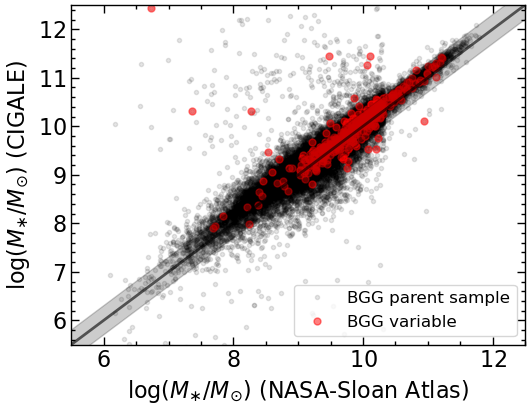

In [41]:
from matplotlib import cm, ticker

mask_det = (dat_nsa['SigQSO'] > 2) & (dat_nsa['SigVary'] > 2) & (dat_nsa['SigQSO'] >= dat_nsa['SigNotQSO'])


results_rv15 = fits.open('cigale/bgg/float/out/results.fits')[1].data

fig, ax = plt.subplots(1,1, figsize=(5.5, 4.3))

dM_rv15 = 0.434*results_rv15['bayes.stellar.m_star_err']/results_rv15['bayes.stellar.m_star']
dMtot_rv15 = np.sqrt(dM_rv15**2 + (0.2)**2)

mask_chi = results_rv15['best.reduced_chi_square'] < 5
x = np.log10(dat_nsa['Mstar'][mask_chi])
y = np.log10(results_rv15['bayes.stellar.m_star'][mask_chi])

mask_dM = np.abs(y - x) < 1
x = x[mask_dM]
y = y[mask_dM]
# Peform the kernel density estimate
xmin, xmax = 5, 13
ymin, ymax = 5, 13
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

#cfset = ax.contourf(xx, yy, f, cmap='Greys', levels=3, zorder=-1)
#cset = ax.contour(xx, yy, f, colors='k')

ax.errorbar(np.log10(dat_nsa['Mstar'][mask_chi]), np.log10(results_rv15['bayes.stellar.m_star'][mask_chi]), markersize=3,
            lw=0.5, linestyle='none', marker='o', color='k', zorder=-1, alpha=0.1, label='BGG parent sample')

ax.errorbar(np.log10(dat_nsa['Mstar'][mask_chi & mask_det]), np.log10(results_rv15['bayes.stellar.m_star'][mask_chi & mask_det]), markersize=5,
            lw=0.5, linestyle='none', marker='o', color='r', zorder=1, alpha=0.5, label='BGG variable')


x = np.linspace(5, 13)
ax.plot(x, x, color='k', zorder=10, alpha=0.6)
ax.fill_between(x, x + 0.3, x - 0.3, alpha=0.2, color='k', zorder=10)

ax.set_xlim(5.5, 12.5)
ax.set_ylim(5.5, 12.5)

ax.set_xlabel(r'$\log (M_{\ast} / M_{\odot})$ (NASA-Sloan Atlas)')
ax.set_ylabel(r'$\log (M_{\ast} / M_{\odot})$ (CIGALE)')

ax.legend(fontsize=12, frameon=True)

fig.tight_layout()

import io
with io.BytesIO() as buffer:
    filesize = (buffer.getbuffer().nbytes * u.byte).to(u.megabyte)
    print(filesize)
    fig.savefig('bgg_mass.pdf', dpi=300)

# stellar massses from RV15 with AGN contribution removed
# generally, these nearby galaxies are host dominated, but tells us that 
# our stellar masses are reasonable for the more host domianted sources

In [42]:
data_bgg

ObjID,RA,Dec,Band,Npoints,Baseline,MedMag,Std,SigVary,SigQSO,SigNotQSO,Mstar,BPT,z,nsaid,z_dr16,Mstar_mendel,NSAID,z_gama,50mpcid,z_best
str9,float64,float64,str1,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,int64,float64,int64,float64
NSA32338,165.2568666,49.9687436,r,123,1876.02589,17.7498718,0.00863076472,0.0,1.378457,0.0,13473236114.2857,1,0.0459751263260841,32338,0.04598,10.128000259399414,32338,-1.0,-1,0.04598
NSA4610,263.7552145,57.05243448,r,261,1552.00244,17.2713766,0.01471833946,0.404314,1.561055,0.00824,636912065.306122,1,0.0472323037683963,4610,0.04723,8.696000099182129,4610,-1.0,-1,0.04723
NSA30953,190.0169633,5.484321547,r,186,1774.15069,18.20166066,0.03128655963,3.581902,1.176183,1.69715,4655425828.57142,2,0.0473862141370773,30953,0.04739,-1.0,30953,-1.0,-1,0.04739
NSA6367,17.18550947,0.9418872917,r,75,1212.94767,18.78117209,0.02746706314,0.466396,1.113544,0.064007,329882481.632653,1,0.0404198467731475,6367,0.04042,-1.0,6367,-1.0,-1,0.04042
NSA12399,149.3889539,1.701860673,r,184,1182.86855,17.64952745,0.01243696148,0.0,1.014212,0.0,3649560816.32653,0,0.0323247872292995,12399,0.03232,9.616999626159668,12399,-1.0,-1,0.03232
NSA4257,260.6403652,63.76327669,r,233,1117.10276,18.76771078,0.03325125329,0.151865,1.320365,0.053861,713694236.734694,1,0.0272146537899971,4257,0.02721,-1.0,4257,-1.0,-1,0.02721
NSA13277,149.6394076,3.055199532,r,222,1182.87,18.33354635,0.01228406147,0.0,0.517527,0.0,6173718987.7551,0,0.0420763529837131,13277,-1.0,-1.0,13277,-1.0,-1,0.0420763529837131
NSA5317,345.4543177,0.5920527603,r,83,1166.91038,16.62091611,0.06837968054,93.506096,0.007598,16.265416,31183642122.4489,2,0.042013332247734,5317,0.04201,10.600000381469727,5317,-1.0,-1,0.04201
NSA9486,118.1837049,44.55671821,r,28,861.7469,19.21490745,0.0806795953,6.637044,0.690311,3.402406,9667024979.59183,1,0.0457814708352088,9486,0.04578,9.777000427246094,9486,-1.0,-1,0.04578


In [43]:

dat_nsa['log_mstar_cigale'] = -1.0
dat_nsa['log_mstar_err_cigale'] = -1.0
# Match on ID?
dat_nsa['log_mstar_cigale'][mask_chi] = np.log10(results_rv15['bayes.stellar.m_star'][mask_chi])
dat_nsa['log_mstar_err_cigale'][mask_chi] = dMtot_rv15[mask_chi]

#data_bgg['log_mstar_err_cigale'][mask_chi] = dMtot_rv15[mask_chi]

### GMF

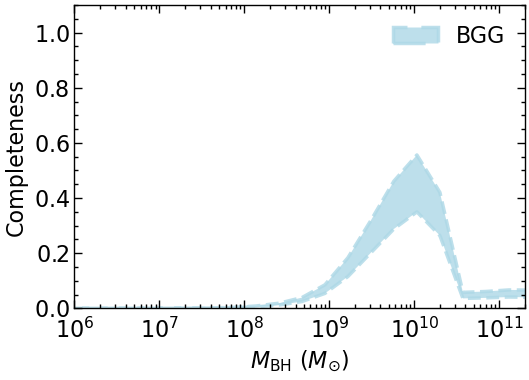

In [44]:
Ms = 10**10.745
phi1 = 10**-2.437
phi2 = 10**-3.201
alpha1 = -0.466
alpha2 = -1.530

_M = np.logspace(5, 11.5, 25)
dM = np.diff(_M)
M = _M[:-1] + dM/2
phidM = np.exp(-M/Ms)*(phi1*(M/Ms)**alpha1 + phi2*(M/Ms)**alpha2) * dM/Ms
#plt.loglog(M, phidM/np.diff(np.log10(_M)))
#plt.ylim(1e-5, 1e0)

# Draw from the GSMF
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

# Plot

#fig, ax0 = plt.subplots(1, 1, figsize=(6, 4.5))
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4.0))

import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg = Table.from_pandas(data_bgg)
data_bgg['nsaid'] = np.array([s[3:] for s in data_bgg['ObjID']], dtype=int)
cat_bgg = SkyCoord(data_bgg['RA'], data_bgg['Dec'], unit=u.deg)

# Variability
omega = (9380*u.deg**2).to(u.sr)
V = (cosmo.comoving_volume(0.055)*omega/(4*np.pi)).value
N_draw = int(V*np.trapz(phidM))
completeness_BGG = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)
    # Add some scatter
    M_star = 10**(np.log10(M_star) + np.random.normal(0, 0.3, len(M_star)))

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, hist_model, color='b', lw=2.5, label='model GSMF')

    stellar_mass = data_bgg['Mstar']
    hist, bin_edges = np.histogram(stellar_mass, bins=_M)

    #ax0.loglog(M, hist, color='b', linestyle='dotted', lw=2.5, label='BGG')

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    completeness_BGG[:,i] = hist/hist_model
    completeness_BGG[~np.isfinite(hist/hist_model),i] = 10
    #ax1.semilogx(M, completeness_BGG, color='b', label='BGG', linestyle='dashed', lw=2.5)

ax1.fill_between(M, np.percentile(completeness_BGG, 16, axis=1), np.percentile(completeness_BGG, 84, axis=1),
                color='lightblue', label='BGG', linestyle='dashed', lw=2.5, alpha=0.8)

#####


ax1.set_xlim(1e6, 2e11)
ax1.set_ylim(0, 1.1)

ax1.set_xscale('log')


ax1.set_xlabel(r'$M_{\rm{BH}}$ ($M_{\odot}$)')
ax1.set_ylabel(r'Completeness')
ax1.legend(fontsize=16)

# Axis
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax1.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax1.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()

In [45]:
os.environ["OMP_NUM_THREADS"] = "1"

#from multiprocessing import Pool
from multiprocess import Pool

from multiprocessing import cpu_count
ncpu = cpu_count() - 1
print("{0} CPUs".format(ncpu))

7 CPUs


detections: 389


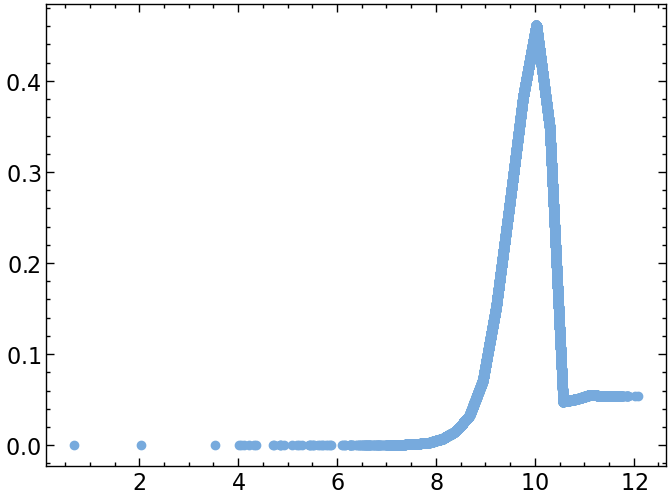

In [46]:
mask_z = np.abs(dat_nsa['z_best'] < 0.055) & (dat_nsa['log_mstar_cigale'] > 0) #& (dat_nsa['50mpcid'] != -1) ##

data_bgg_z = dat_nsa[mask_z]

mask_det = (data_bgg_z['SigQSO'] > 2) & (data_bgg_z['SigVary'] > 2) & (data_bgg_z['SigQSO'] >= data_bgg_z['SigNotQSO'])

print('detections:', len(data_bgg_z[mask_det]))

#mask_non = (data_bgg['SigVary'] < 2)
mask_non = ~mask_det # This should be correct, even "variable" non-AGN things (SN, etc should count)

data_bgg_det = data_bgg_z[mask_det]
data_bgg_non = data_bgg_z[mask_non]

x = np.concatenate([data_bgg_det['log_mstar_cigale'], data_bgg_non['log_mstar_cigale']])
xerr = np.concatenate([data_bgg_det['log_mstar_err_cigale'], data_bgg_non['log_mstar_err_cigale']])

# 10
m = np.concatenate([data_bgg_det['MedMag'], data_bgg_non['MedMag']])
# Use 2-3* rms as the upper limit
dm = np.concatenate([data_bgg_det['Std'], data_bgg_non['Std']]) # smal dm for non detections helps
z = np.concatenate([data_bgg_det['z'], data_bgg_non['z']])
sigma_var = np.concatenate([data_bgg_det['SigVary'], data_bgg_non['SigVary']])

#TODO: separate into detections and non detections and fix errors, assume ~10 percent error
f = 10**(23 -0.4*(m + 48.6)) # R -> f [Jy]
d_L = cosmo.luminosity_distance(z).to(u.cm).value
L = f*(4*np.pi*d_L**2) * 1e-23 * 4.5e14 # Lv [erg/s/Hz]

# Convert to L to make things more intuitive using MacLeod relation
y = 41.7 - 0.7 - 3.3*np.log10(dm) - 4 # roughly match 1/Vmax

#xerr = np.full_like(y, 0.3) # Change this and things get weird..
yerr = np.concatenate([len(data_bgg_det)*[0.05], len(data_bgg_non)*[-1]])

# assume errors of ~10 percent
yerr[yerr==0.0] = 0.434*np.log10(0.1 * np.log(10)/2.5 * L[yerr==0.0]*dm[yerr==0.0]) / y[yerr==0.0]

p_obs = np.clip(np.interp(x, np.log10(M), np.mean(completeness_BGG, axis=1)), 1e-6, 1)
#p_obs = np.ones_like(x)
plt.scatter(x, p_obs)

# Save the input for multiwavelength analysis!
tvar = Table([x, y, xerr, yerr, p_obs], names=['x', 'y', 'xerr', 'yerr', 'pobs'])
tvar.write('tvar.txt', overwrite=True, format='ascii')

## INFERENCE
nsamp=1000
nburn=200

color='C1'
ylims=[None, None]

#  log_ms0, delta1, ep, log_lam_min, log_lam_max, log_lam_s, log_f, f_a, delta, theta2, l0, xi, a = theta
pos = [9.0, 1.0,    1.5, -12.5,       2.8,       -2.0,        -0.8,  0.05, 2.0,      1.5, 52, 0.2, 0.5]

pos = np.array(pos) + 1e-4 * np.random.randn(32, len(pos))
nwalkers, ndim = pos.shape

# log probability global
args_global = (x, y, xerr, yerr, p_obs)
def log_probability(theta):
    x, y, xerr, yerr, p_obs = args_global
    lp = log_prior(theta)
    ll = log_likelihood(theta, x, y, xerr, yerr, p_obs)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [47]:
ncpu = 1

if ncpu > 1:
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
        sampler.run_mcmc(pos, nsamp, progress=True);
else:
# Sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ],)
    sampler.run_mcmc(pos, nsamp, progress=True);

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/colinburke/miniconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 28%|██▊       | 275/1000 [6:56:13<17:42:54, 87.97s/it] Traceback (most recent call last):
  File "/Users/colinburke/miniconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_36864/2541845034.py", line 65, in log_probability
    ll = log_likelihood(theta, x, y, xerr, yerr, p_obs)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_36864/89395123.py", line 48, in log_likelihood
    lam_C = 10**np.arange(log_lam_min, log_lam_max, .01)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
 28

emcee: Exception while calling your likelihood function:
  params: [ 9.00000496e+00  9.99845743e-01  1.50006871e+00 -1.24998184e+01
  2.79994501e+00 -1.99988755e+00 -8.00008313e-01  5.01379357e-02
  1.99989767e+00  1.49997613e+00  5.19998853e+01  1.99950983e-01
  4.99940997e-01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

(2560, 13)


95% CI:  9.321371634736316
y lim 42.51810921065939


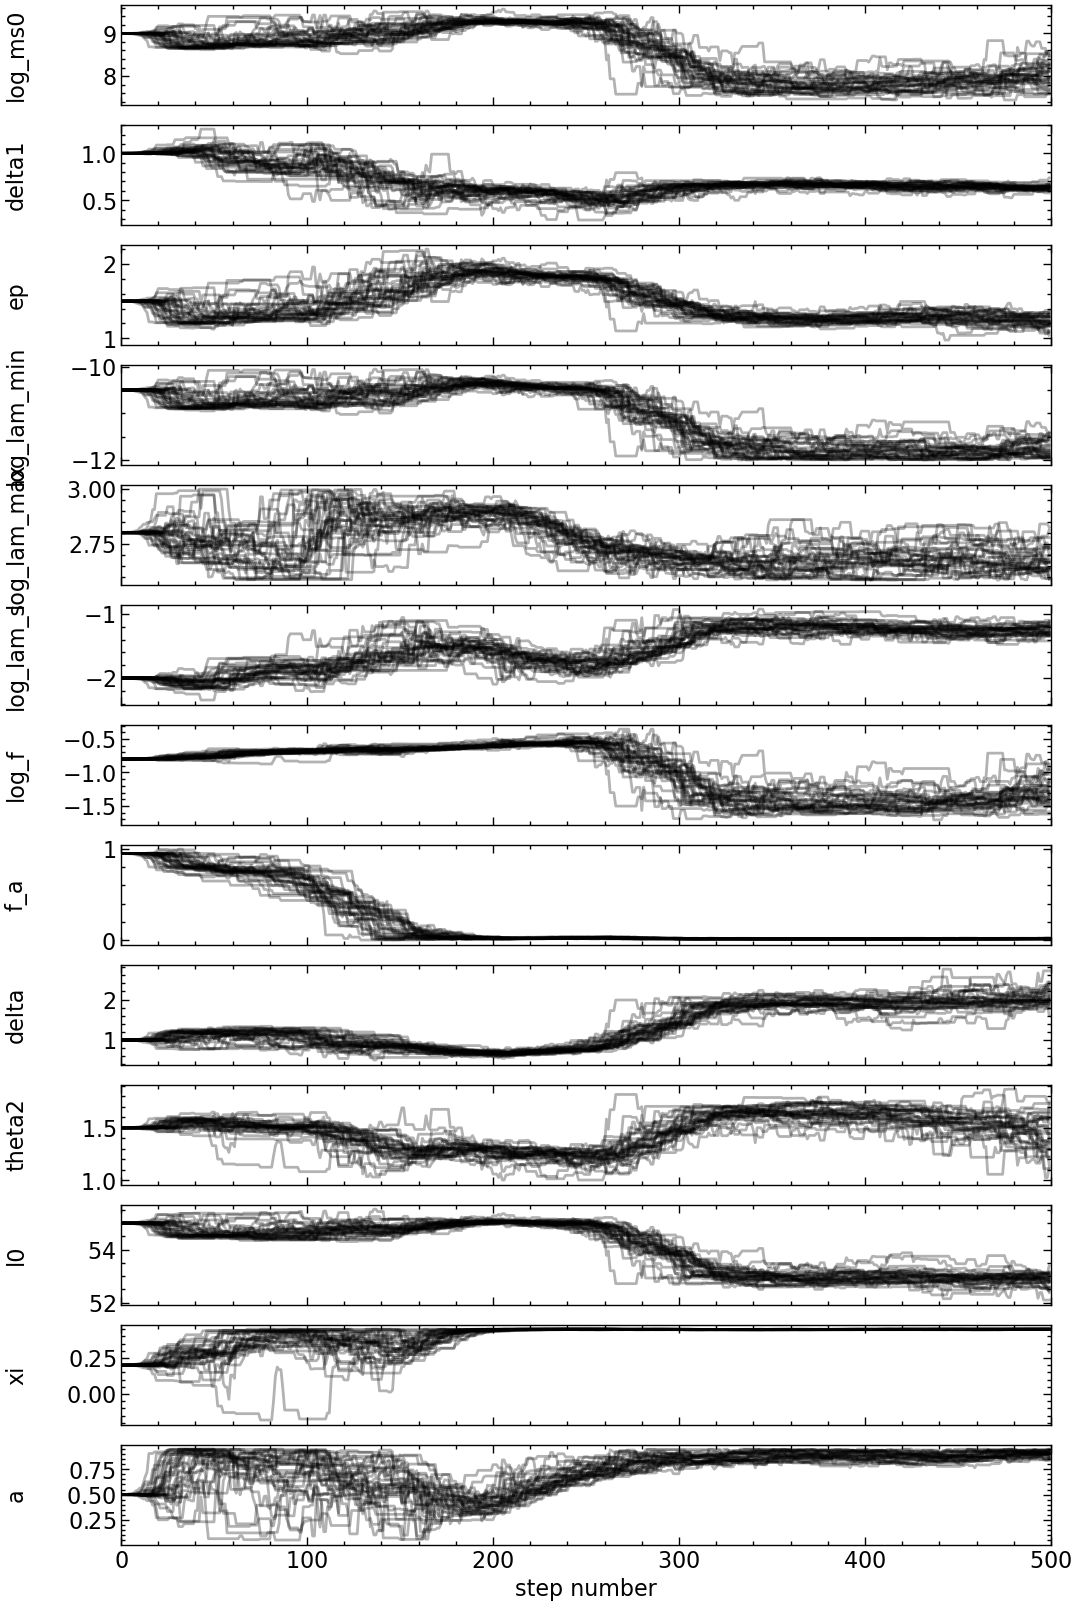

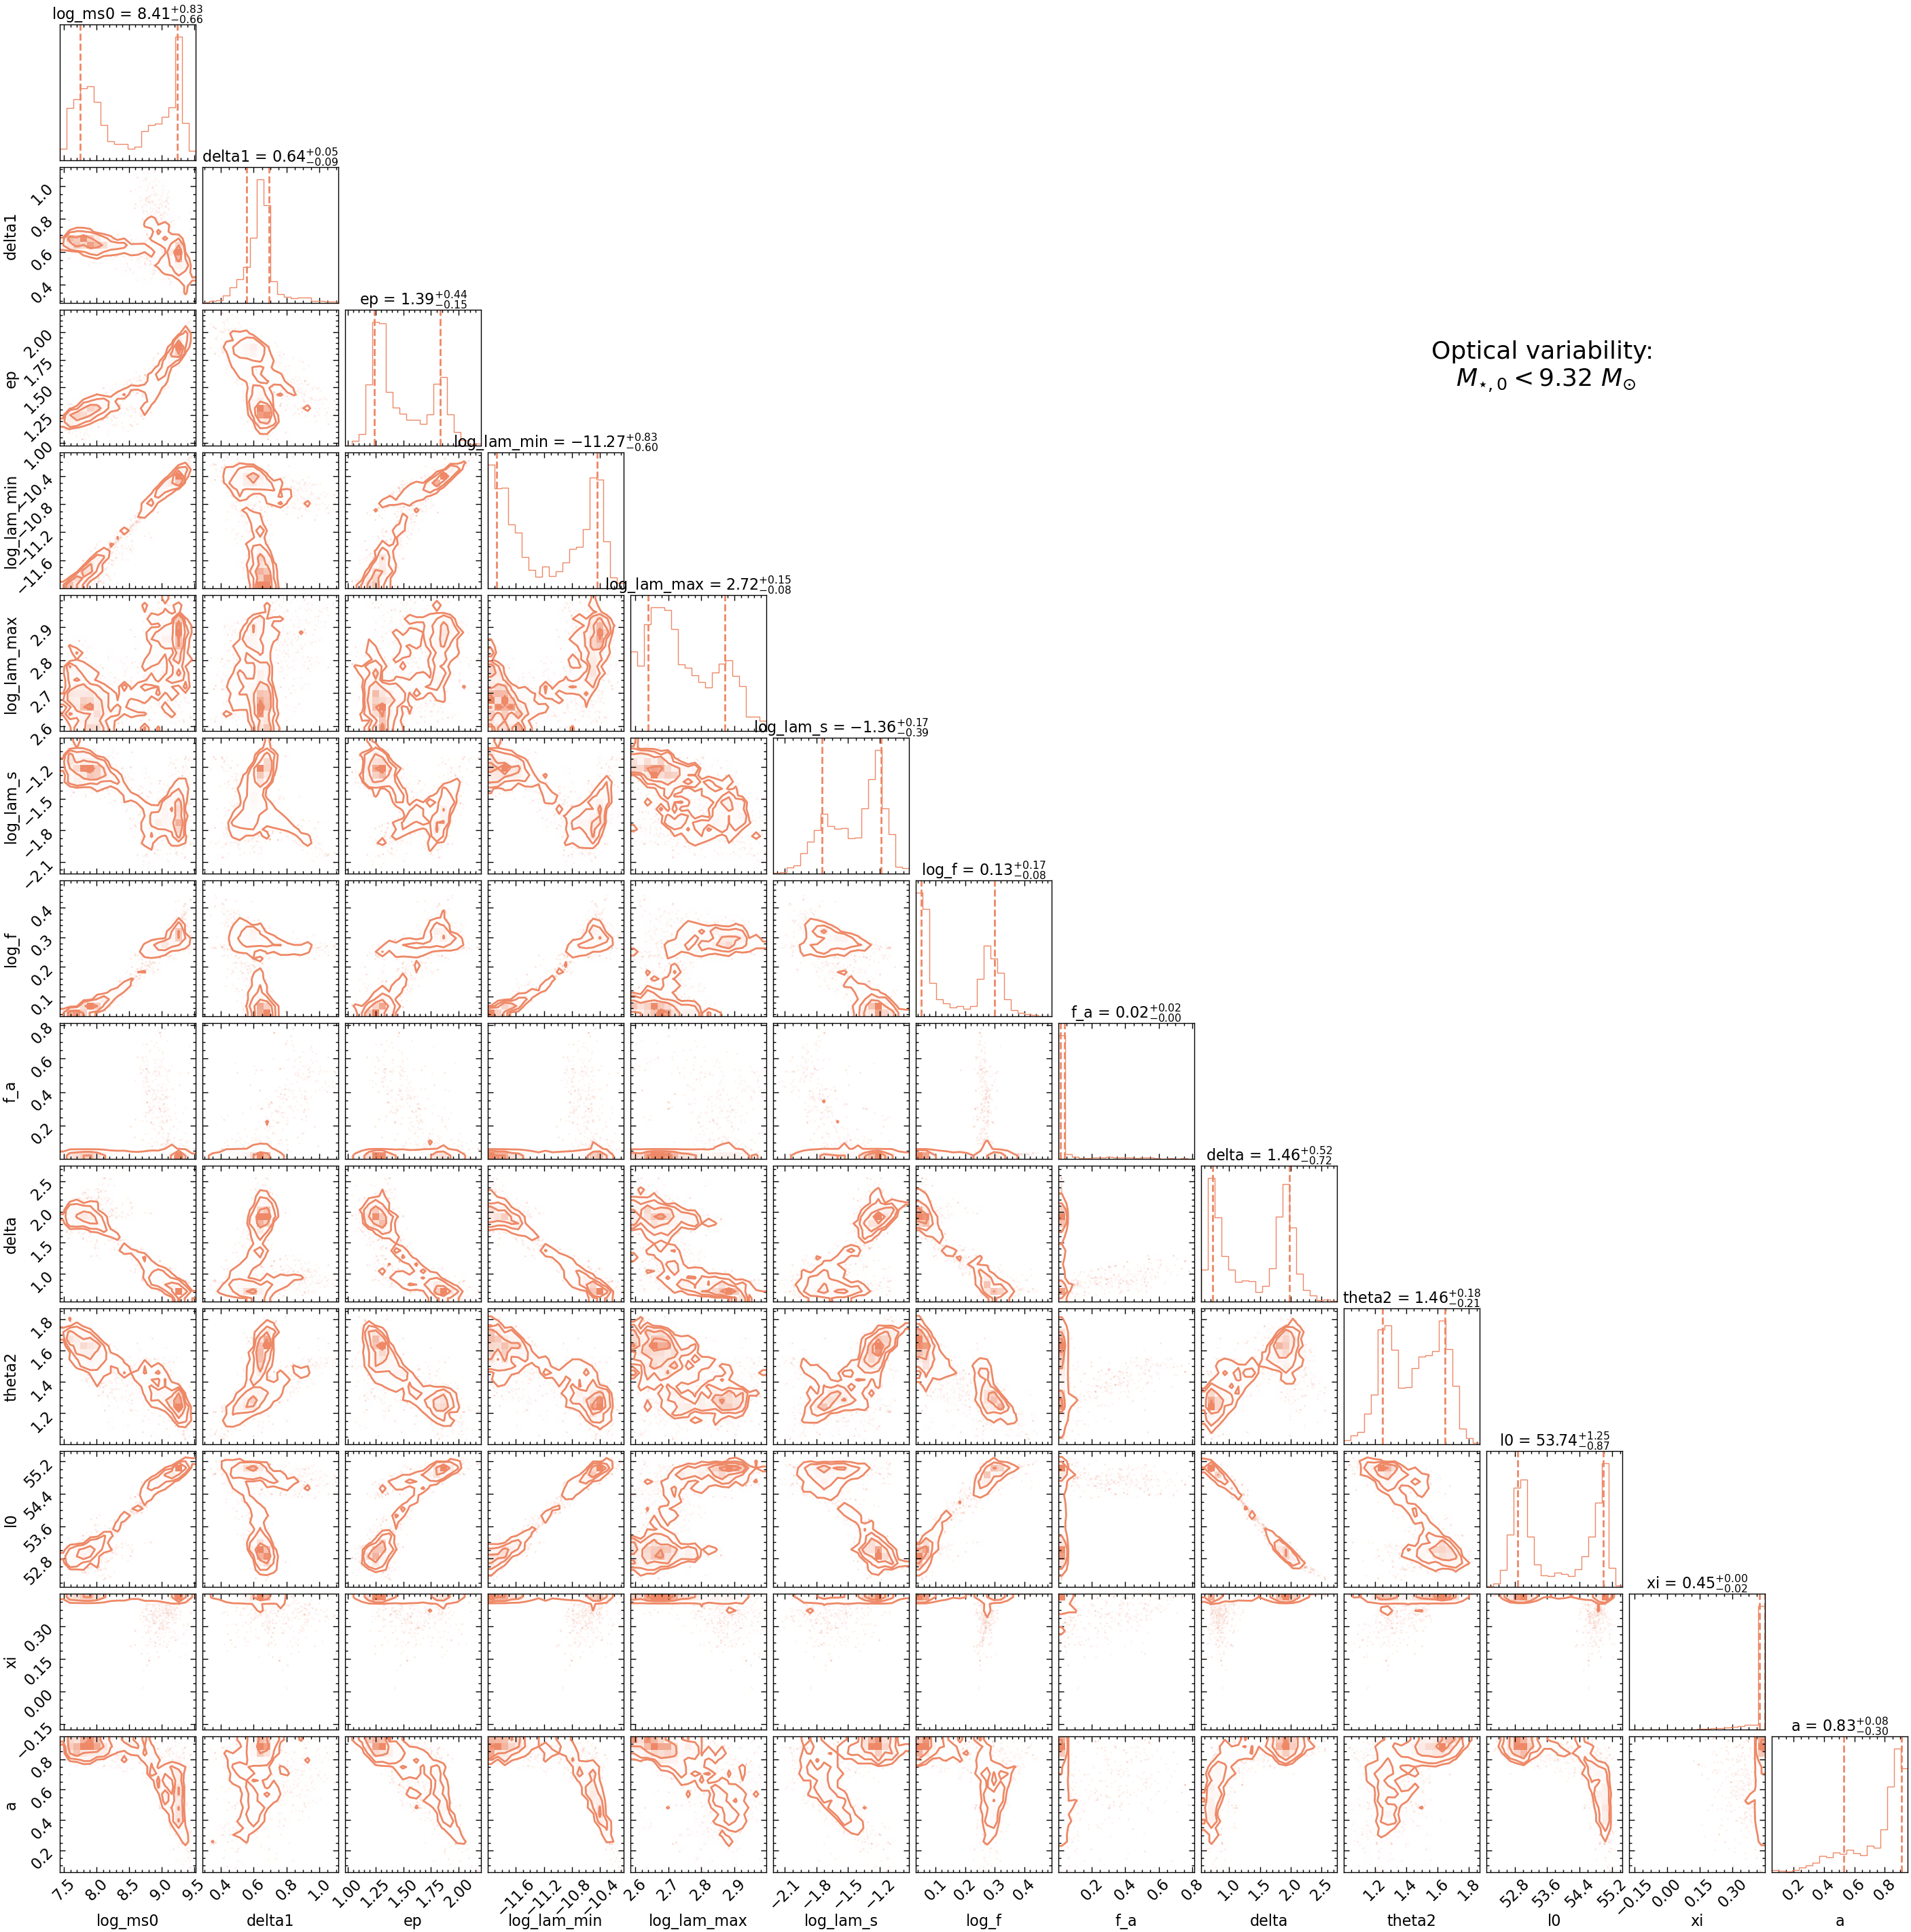

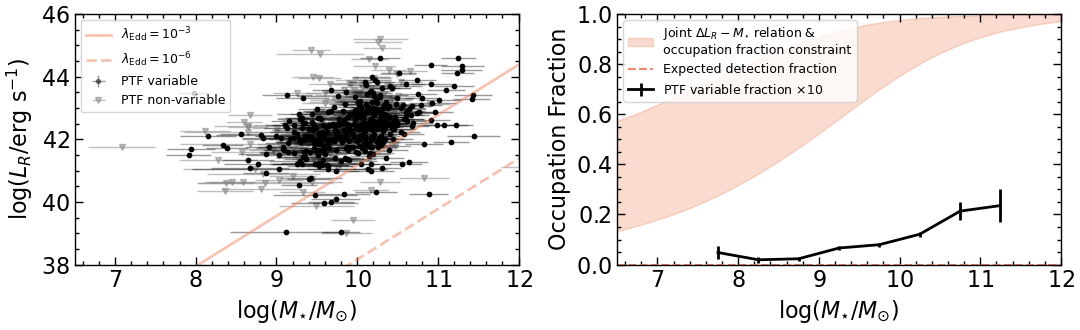

In [ ]:
# Plot
fig, axes = plt.subplots(ndim, figsize=(12, 20), sharex=True)
samples = sampler.get_chain()

# logms0, alpha, beta, log_f, f_a, l0, xi, a, s 
labels = ['log_ms0', 'delta1', 'ep', 'log_lam_min', 'log_lam_max', 'log_lam_s', 'log_f', 'f_a', 'delta', 'theta2', 'l0', 'xi', 'a']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)
print(flat_samples.shape)

# Corner
flat_samples[:,6] = np.exp(2*flat_samples[:,6]) # sigma
fig_corner = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.84], color=color, show_titles=True)

# TODO::::: Increase the 1st column limit + 1 and use 95th percentile

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
#inds = np.random.randint(len(flat_samples), size=100)

# Plot data
x_eval = np.linspace(5, 15, 200)
axes[0].scatter(x[yerr > 0], y[yerr > 0], marker='.', color='k')
axes[0].errorbar(x[yerr > 0], y[yerr > 0], elinewidth=1,
                xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                fmt=".k", capsize=0, alpha=0.4, label='PTF variable')
# Pick random
if len(x[yerr < 0]) > 150:
    ind_rand = np.random.choice(len(x[yerr < 0]), 150, replace=False)
else:
    ind_rand = np.arange(len(x[yerr < 0]))
axes[0].errorbar(x[yerr < 0][ind_rand], y[yerr < 0][ind_rand],
                    xerr=xerr[yerr < 0][ind_rand], elinewidth=1, markersize=5,
                    marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1, label='PTF non-variable')
#axes[0].errorbar(x[(yerr < 0) & (y<40)] + xp, y[(yerr < 0) & (y<40)] + yp,
#                    xerr=xerr[(yerr < 0) & (y<40)], elinewidth=1,
#                    marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1)
axes[0].legend(fontsize=14)
axes[0].set_xlim([6.5, 12])
axes[0].set_ylim([38, 46])
axes[0].set_xlabel(r'$\log(M_{\star} / M_{\odot})$')
axes[0].set_ylabel(r'$\log(L_{R} / {\rm{erg}}\ {\rm{s}}^{-1})$')

# Linear relation
# Accretion rates
x_bh_eval = 7.43 + 1.61*(x_eval - np.log10(3e10)) # 0.81
BC = 0.7
y_eval = -BC + 38.2 + x_bh_eval
axes[0].plot(x_eval, y_eval-3, color=color, alpha=0.5, zorder=2, label=r'$\lambda_{\rm{Edd}} = 10^{-3}$')

axes[0].plot(x_eval, y_eval-6, color=color, alpha=0.5, zorder=2, label=r'$\lambda_{\rm{Edd}} = 10^{-6}$', linestyle='dashed')

# Limits
log_ms0_low = np.percentile(flat_samples[:,0], 95)
log_ms0_high = np.percentile(flat_samples[:,0], 5)
print('95% CI: ', log_ms0_low)

# Occupation fraction
foccs = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    xii = np.exp(s[8])
    theta2i = s[9]
    foccs[i,:] =  1/(1 + xii * np.exp(-theta2i*(x_eval - s[0])))**(1/xii)

axes[1].fill_between(x_eval, np.percentile(foccs, 16, axis=0),  np.percentile(foccs, 84, axis=0), color=color, alpha=0.3,
                        label=r'Joint $\Delta L_{R} - M_{\star}$ relation &'+'\n'+'occupation fraction constraint')

# Expectation fraction
y_lim = np.percentile(y[(yerr<0)], 50)

delta1 = np.median(flat_samples[:,1])
ep = np.median(flat_samples[:,2])
log_lam_min = np.median(flat_samples[:,3])
log_lam_max = np.median(flat_samples[:,4])
lam_s = 10**np.median(flat_samples[:,5])

dlogl = 0.1
log_lam_eval = np.arange(log_lam_min, 1, dlogl)
lam_eval = 10**log_lam_eval
dlam_eval = np.diff(lam_eval)
print('y lim', y_lim)

lam_C = 10**np.arange(log_lam_min, log_lam_max, 0.01)
C = 1/trapezoid( ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1), dx=np.diff(lam_eval))
pdf = C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)

log_lam_lims = y_lim + BC - 38.2 - x_bh_eval

fexp = np.zeros_like(x_bh_eval)
for i, x_bhi in enumerate(x_bh_eval):
    lam_int = 10**np.arange(log_lam_lims[i], log_lam_max, dlogl)
    log_lam_int = np.log10(lam_int)
    # 
    L0 = 10**s[10]
    xi = 0.23
    a = .5
    ls = 10**(y_lim)
    f1 = 1 - (1 + 3*(ls/L0)**(1 - 2*xi))**-a
    fexp[i] = f1 * .85*trapezoid(np.interp(log_lam_int, log_lam_eval, pdf), dx=np.diff(lam_int)) / trapezoid(pdf, dx=np.diff(lam_eval))

axes[1].plot(x_eval, fexp, color=color, lw=1.5, linestyle='dashed', label=r'Expected detection fraction')


# Histogram
hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(5, 12, 0.5))
hist_all, bin_edges = np.histogram(x,  bins=np.arange(5, 12, 0.5))
frac_det = hist_det/hist_all

bincenter = (bin_edges[:-1] + bin_edges[1:]) / 2

axes[1].errorbar(bincenter[hist_det>0], 10*frac_det[hist_det>0],
                    yerr=10*st.binom.std(hist_all[hist_det>0], frac_det[hist_det>0])/hist_all[hist_det>0],
                    color="k", capsize=0, label=r'PTF variable fraction $\times  10$')
axes[1].set_xlim([6.5, 12])
axes[1].set_ylim([0, 1])
axes[1].set_xlabel(r"$\log(M_{\star} / M_{\odot})$")
axes[1].set_ylabel(r"Occupation Fraction")

axes[0].legend(loc=0, fontsize=9, frameon=True)
axes[1].legend(loc='upper left', fontsize=9, frameon=True)

## IF you see nothing it means init is outside of prior bounds 
# or you have inf/nans in the data / likelihood somewhere

fig_corner.text(.8, .8, 'Optical variability: \n'+r'$M_{\star,0} < $'+f'{np.round(log_ms0_low,2)}'+r' $M_{\odot}$', ha='center', fontsize=26)

fig.tight_layout()
fig_corner.savefig('corner_ptf.pdf', dpi=300)
fig.savefig('bhofvar.pdf', dpi=300)

### Galaxy stellar mass function

1.7161493978431007e-12
[6.97857864e-05 1.00445444e-04 1.44575102e-04 2.08092665e-04
 2.99516007e-04 4.31105241e-04 6.20506833e-04 8.93120039e-04
 1.28550301e-03 1.85027536e-03 2.66317454e-03 3.83321249e-03
 5.51729443e-03 7.94126019e-03 1.14301700e-02 1.64518960e-02
 2.36798650e-02 3.40833667e-02 4.90575384e-02 7.06104562e-02
 1.01632424e-01 1.46283569e-01 2.10551730e-01 3.03055436e-01
 4.36199681e-01 6.27839462e-01 9.03674182e-01 1.30069401e+00
 1.87214036e+00 2.69464570e+00 3.87851018e+00 5.58249318e+00
 8.03510334e+00 1.15652422e+01 1.66463107e+01 2.39596937e+01
 3.44861353e+01 4.96372592e+01 7.14448713e+01 1.02833430e+02
 1.48012226e+02 2.13039853e+02 3.06636691e+02 4.41354323e+02
 6.35258742e+02 9.14353045e+02 1.31606452e+03 1.89426374e+03
 2.72648876e+03 3.92434316e+03]


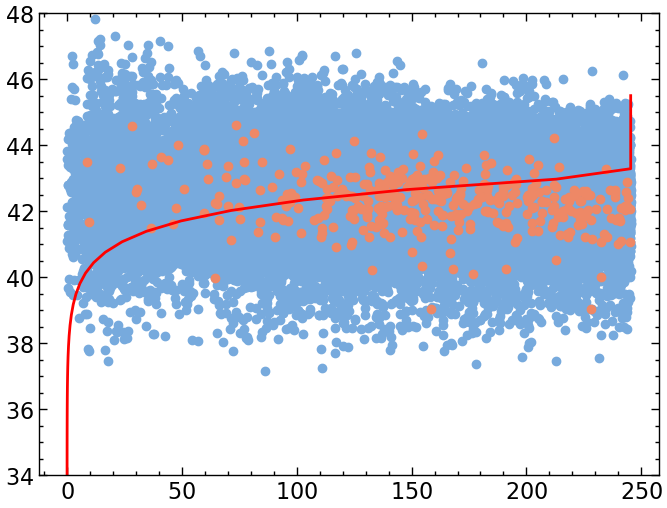

In [ ]:
dist = cosmo.luminosity_distance(z)

# 1/Vmax
log_l_eval = np.linspace(30, 45.5)
l_eval = 10**log_l_eval
sens_lim = 2.5 * np.median( 10**y[yerr>0] / ( 4 * np.pi * (dist[yerr>0]).to(u.cm).value**2 )) # erg / s 
print(sens_lim)

d = np.sqrt(l_eval / (sens_lim * 4*np.pi)) # erg / s / (# erg / s )
print((d*u.cm).to(u.Mpc).value)
d = np.clip((d*u.cm).to(u.Mpc).value, 0, np.max(dist).to(u.Mpc).value)
Vmax = 4/3*np.pi*d**3 * 30000/41253 # area
#log_l_med = np.log10(sens_med*4*np.pi*d**2)
plt.plot(d, log_l_eval, color='r')
plt.ylim(34, 48)

plt.scatter(dist, y)
plt.scatter(dist[yerr>0], y[yerr>0]) 

def invVmax_l(logl):
        return np.interp(logl, log_l_eval, 1/Vmax)


In [ ]:
def logGSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    # dN/dlogM
    phi = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))
    
    return phi

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_8634/1511998596.py:148: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_8634/1511998596.py:189: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


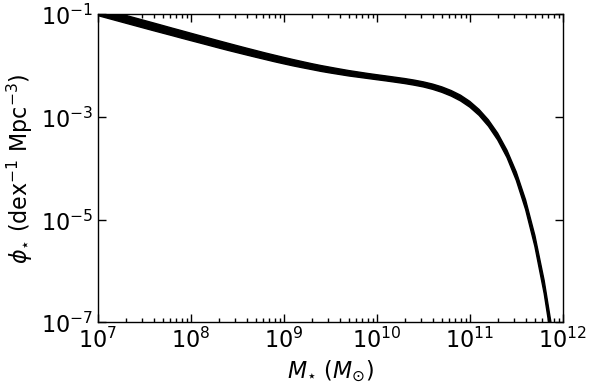

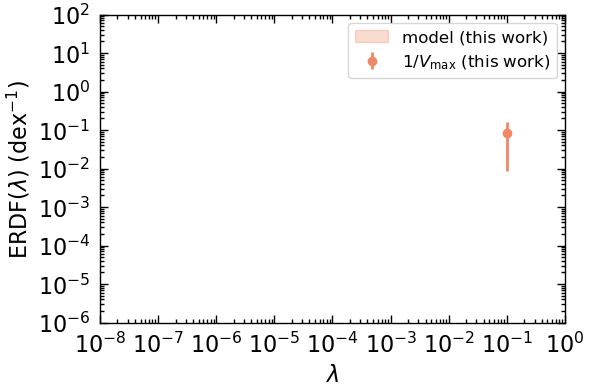

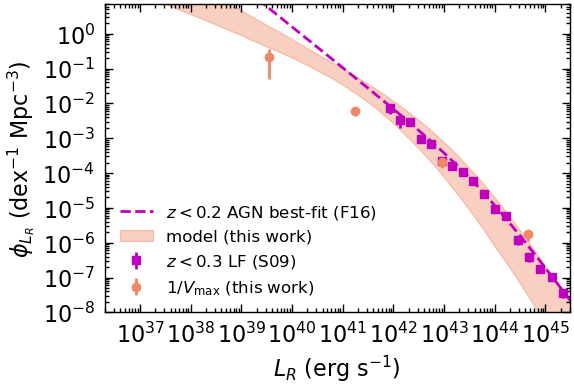

In [ ]:
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 4.0))
ax1.set_xscale('log')
ax1.set_yscale('log')

fig2, ax2 = plt.subplots(1, 1, figsize=(6, 4.0))
ax2.set_xscale('log')
ax2.set_yscale('log')

fig3, ax3 = plt.subplots(1, 1, figsize=(6, 4.0))
ax3.set_xscale('log')
ax3.set_yscale('log')

#TODO: Check bin center

# grid
dlogm = 0.1
logms = np.arange(2.0, 20.5, dlogm)
ms = 10**logms
dms = np.diff(ms)

dloglam = 0.1
loglam_eval = np.arange(-12., 4., dloglam)
lam_eval = 10**loglam_eval
dlam_eval = np.diff(lam_eval)

#Nsamp = 200
Nsamp = len(flat_samples)//5

gsmf = np.zeros([len(logms), Nsamp])
gsmf_blue = np.zeros([len(logms), Nsamp])
gsmf_red = np.zeros([len(logms), Nsamp])

bhmf1_blue = np.zeros([len(logms), Nsamp])
bhmf1_red = np.zeros([len(logms), Nsamp])

# BHOF should not depend on galaxy color type
bhmf_xray = np.zeros([len(logms), Nsamp])
bhmf_xray_blue = np.zeros([len(logms), Nsamp])
bhmf_xray_red = np.zeros([len(logms), Nsamp])

bhmf_radio = np.zeros([len(logms), Nsamp])
bhmf_radio_blue = np.zeros([len(logms), Nsamp])
bhmf_radio_red = np.zeros([len(logms), Nsamp])

bhmf_optical = np.zeros([len(logms), Nsamp])
bhmf_optical_blue = np.zeros([len(logms), Nsamp])
bhmf_optical_red = np.zeros([len(logms), Nsamp])

bhlf = np.zeros([len(logms), Nsamp])
bhlf_conv = np.zeros([len(logms), Nsamp])


erdfs = np.zeros([len(loglam_eval), Nsamp])


foccs = np.zeros([Nsamp, len(logms)])

focc_radio = np.load('focc_vlass.npy')
focc_optical = np.load('focc_ptf.npy')

for i in range(Nsamp):

    # total BH mass function is dominated by early population
    # GSH20, early-type / E, limits
    alpha_red = np.random.normal(7.89, 0.09, size=1)
    beta_red = np.random.normal(1.33, 0.12, size=1)
    sigma_red = np.random.normal(0.65, 0.05, size=1)
    logms0_red = np.log10(3*1e10)

    # grid
    logmb_red = alpha_red + beta_red*(logms - logms0_red)
    mb_red = 10**logmb_red
    dmb_red = np.diff(mb_red)

    # BH mass - stellar mass relation
    # RV15 / similar to GSH20, early-type
    alpha_blue = np.random.normal(7.45, 0.08, size=1)
    beta_blue = np.random.normal(1.05, 0.11, size=1)
    sigma_blue = np.random.normal(0.55-0.3, 0.02, size=1) # Assume 10% error on scatter
    logms0_blue = 11

    # grid
    logmb_blue = alpha_blue + beta_blue*(logms - logms0_blue)
    mb_blue = 10**logmb_blue
    dmb_blue = np.diff(mb_blue)
    
    x_bh_eval = 7.43 + 1.61*(logms - np.log10(3e10)) # 0.81
    logl = -.7 + 38.2 + x_bh_eval
    l = 10**logl
    dl = np.diff(l)
    dlogl = np.diff(logl)[0]

    gsmf[:,i] = logGSMF(ms)

    # Occupation fraction
    xii = flat_samples[i,8]
    theta2i = flat_samples[i,9]
    foccs[i,:] = 1/(1 + xii * np.exp(-theta2i*(logms - flat_samples[i,0])))**(1/xii)

    # Type 1 fraction
    L0 = 10**flat_samples[i,10]
    xi = 0.23
    a = .5
    f1 = 1 - (1 + 3*(l/L0)**(1 - 2*xi))**-a

    # Convolve
    delta1 = flat_samples[i,1]
    ep = flat_samples[i,2]
    lam_s = 10**flat_samples[i,5]
    C = 1/trapezoid( ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1), dx=np.diff(lam_eval))
    pdf_pl = C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)
    erdfs[:,i] = pdf_pl

    dBC = 4.0 #3.0 ## adjust this thing
    BC = 0.7 + dBC

    bhmfi = np.array([np.trapz(foccs[i,:] * gsmf[:,i] * st.norm.pdf(logmbi-logms, loc=logmb_red-logms, scale=sigma_red)*dlogm) for logmbi in logmb_red])
    bhlf[:,i] = np.array([np.trapz(np.interp(logli - loglam_eval, logmb_red + 38.2 - BC, .1 *f1 * bhmfi) * pdf_pl * dloglam) for logli in logl])

    # int per dex * dex PDF = per dex
    # # PDF units are in per dex! ##


# FOTOPOLOU DENSITY
Gamma = 1.8

gamma1 = 0.87
gamma2 = 2.40
A = 10**-5.97
L0 = 10**43.77
L = np.logspace(36, 47)
# # https://www.aanda.org/articles/aa/pdf/2016/03/aa24763-14.pdf
L_F16 = L*(10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma))
LF_F16 = A/((L/L0)**(gamma1) + (L/L0)**gamma2)


#########################################
# GSMF
#########################################

# Plot
ax1.fill_between(ms[:-1], np.percentile(gsmf[:-1], 16, axis=1),
           np.percentile(gsmf[:-1], 84, axis=1), color='k')
ax1.set_ylim(1e-7, 1e-1)
ax1.set_xlim(1e7, 1e12)
ax1.set_xlabel(r'$M_{\star}\ (M_{\odot})$')
ax1.set_ylabel(r'$\phi_{\star}$ (dex$^{-1}$ Mpc$^{-3})$')
fig1.show()

#########################################
# ERDF
#########################################


L_S09 = l_eval
Ls = 10**(44.37 - .7)
PHI_S09 = (2.54*1e-5) /( (L_S09/Ls)**(2.17-1) + (L_S09/Ls)**(2.95-1) )

# Normalize
xi_star = np.ones(np.shape(bhlf)[1])
for i in range(np.shape(bhlf)[1]):
        xi_star[i] = np.interp(1e44, L_S09, PHI_S09) / np.interp(1e44, l, bhlf[:,i])
        erdfs[:,i] = erdfs[:,i]*xi_star[i]

bhlf = bhlf*np.median(xi_star)

# Plot
ax2.fill_between(lam_eval[:-1], np.percentile(erdfs[:-1], 16, axis=1),
           np.percentile(erdfs[:-1], 84, axis=1), color=color, alpha=0.3, label='model (this work)')

# 1/Vmax
x_bh = 7.43 + 1.61*(x - np.log10(3e10)) # 0.81
log_lam = y + BC - 38.2 - x_bh # residual

_dloglam = 1.0
_loglam_eval = np.arange(-6.5, 0, _dloglam)
#h, bin_edges = np.histogram(log_lam[yerr>0], bins=_loglam_eval)
n, bin_edges = np.histogram((log_lam)[(yerr > 0)], weights=invVmax_l(y)[(yerr > 0)]/p_obs[(yerr > 0)], bins=_loglam_eval) # /p_obs[(yerr > 0)]
err, bin_edges = np.histogram((log_lam)[(yerr > 0)], weights=(invVmax_l(y)[(yerr > 0)]/p_obs[(yerr > 0)])**2, bins=_loglam_eval)

norm = 1*np.diff(bin_edges)
ax2.errorbar(10**(bin_edges[:-1]+_dloglam/2), n/norm, yerr=np.sqrt(err)/norm, linestyle='none',
        color=color, marker='o', label=r'$1/V_{\rm{max}}$ (this work)')
        
ax2.set_ylim(1e-6, 1e2)
ax2.set_xlim(1e-8, 1e0)
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'ERDF$({\lambda})$ (dex$^{-1}$)')
fig2.show()

#########################################
# LF
#########################################

# SDSS
# https://ui.adsabs.harvard.edu/abs/2009A%26A...507..781S/exportcitation
xlocal = np.array([42.63,42.83,43.03,43.24,43.44,43.65,43.86,44.07,44.28,44.49,\
              44.71,44.93,45.15,45.38,45.60,45.82,46.05,46.28,46.51]) -.7
ylocal = np.array([-2.12,-2.48,-2.52,-3.02,-3.16,-3.64,-3.80,-3.98,-4.24,-4.59,\
              -5.02,-5.24,-5.93,-6.42,-6.77,-6.98,-7.45,-7.78,-8.34])
dylocal_hi = np.array([.1, .13, .07, .07, .07, .08, .07, .07, .07, .08, .06, .06, .1, .09, .09, .08, .1, .12, .19])
dylocal_lo = np.array([.15, .18, .1, .09, .1, .08, .08, .1, .1, .1, .08, .08, .11, .11, .1, .09, .11, .17, .38])

dylocal = 2.303*np.array([dylocal_lo, dylocal_hi])*10**ylocal
ax3.errorbar(10**xlocal, 10**ylocal, yerr=dylocal, c='m', marker='s', label=r'$z<0.3$ LF (S09)', linestyle='none')


ax3.plot(L_S09, PHI_S09 /np.diff(np.log10(L_S09))[0], color='m', linestyle='dashed', label='$z<0.2$ AGN best-fit (F16)')


bins = np.linspace(37., 45.5, 6)
n, bins = np.histogram((y)[(yerr > 0)], weights=invVmax_l(y)[(yerr > 0)]/p_obs[(yerr > 0)], bins=bins) # /p_obs[(yerr > 0)]
err, bins = np.histogram((y)[(yerr > 0)], weights=(invVmax_l(y)[(yerr > 0)]/p_obs[(yerr > 0)])**2, bins=bins)
bin_width = (bins[:-1] + bins[1:])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_widths = 2.303*np.diff(bins) * 10**bin_centers
ax3.errorbar(10**bin_centers, n/np.diff(bins), yerr=np.sqrt(err)/np.diff(bins),
             linestyle='none', marker='o', color=color, label=r'$1/V_{\rm{max}}$ (this work)')

ax3.fill_between((l[:-1]), (np.percentile(bhlf[:-1], 16, axis=1)),
                (np.percentile(bhlf[:-1], 84, axis=1)), color=color, alpha=0.4, label='model (this work)')

# Axis
for ax in [ax2, ax3]:
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
        ax.xaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.tick_params(axis='x', which='major', pad=7)

        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
        ax.yaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.tick_params(axis='y', which='major', pad=7)

#ax3.set_xlim(1e37, 1e48)
ax3.set_xlim(2e36, 3e45)
ax3.set_ylim(1e-8, 7e0)
ax3.set_xlabel(r'$L_{R}$ (erg s$^{-1}$)')
ax3.set_ylabel(r'$\phi_{L_R}$ (dex$^{-1}$ Mpc$^{-3})$')
ax2.legend(fontsize=12, frameon=True)
ax3.legend(fontsize=12)

fig2.savefig('erdfvar.pdf', dpi=300)
fig3.savefig('lfvar.pdf', dpi=300)

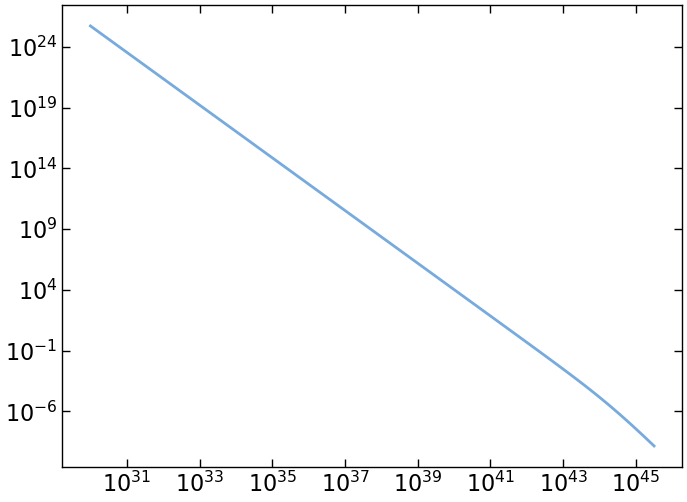

In [ ]:
L_S09 = l_eval
Ls = 10**44.37
PHI_S09 = (2.54*1e-5) /( (L_S09/Ls)**2.17 + (L_S09/Ls)**2.95 )
plt.loglog(L_S09, PHI_S09 * np.diff(np.log10(L_S09))[0]/np.log(10))

In [ ]:
np.diff(np.log10(L_S09))[0]

0.31632653061224403

In [ ]:
np.diff(L_S09)

array([1.07169840e+30, 2.22023586e+30, 4.59965908e+30, 9.52910635e+30,
       1.97414344e+31, 4.08982980e+31, 8.47289386e+31, 1.75532806e+32,
       3.63651034e+32, 7.53375266e+32, 1.56076633e+33, 3.23343711e+33,
       6.69870650e+33, 1.38776995e+34, 2.87504079e+34, 5.95621741e+34,
       1.23394861e+35, 2.55636935e+35, 5.29602630e+35, 1.09717692e+36,
       2.27301967e+36, 4.70901122e+36, 9.75565101e+36, 2.02107666e+37,
       4.18706128e+37, 8.67432815e+37, 1.79705918e+38, 3.72296462e+38,
       7.71285984e+38, 1.59787194e+39, 3.31030874e+39, 6.85796132e+39,
       1.42076275e+40, 2.94339191e+40, 6.09782032e+40, 1.26328446e+41,
       2.61714439e+41, 5.42193385e+41, 1.12326117e+42, 2.32705837e+42,
       4.82096309e+42, 9.98758153e+42, 2.06912567e+43, 4.28660433e+43,
       8.88055134e+43, 1.83978240e+44, 3.81147425e+44, 7.89622511e+44,
       1.63585969e+45])